In [1]:
"""
Example of loading in CIFAR10 data set using torchvision tools.

From:
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    
"""

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Files already downloaded and verified
Files already downloaded and verified


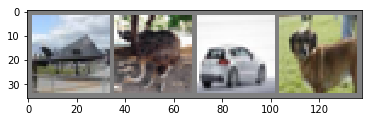

plane    bird     car     dog


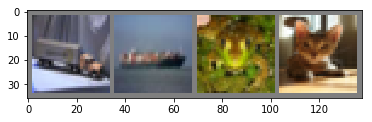

truck    ship    frog     cat


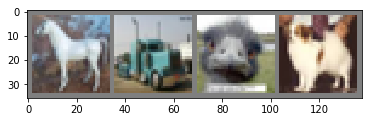

horse   truck    bird     dog


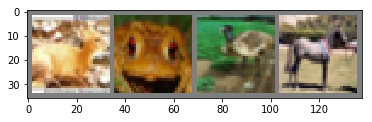

 deer    frog    bird   horse


In [2]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# Transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Note: num_workers=0 required when running on Windows
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Arrange to display some example images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(trainloader)

for i in range(0,4):
    # Get the next batch of images
    images, labels = dataiter.next()

    # Show images
    imshow(torchvision.utils.make_grid(images))
    # Print labels below
    print('   '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # inputChan, outputChan, N_Filters
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # view images as a vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
net = Net()
print(net)

# Define cost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print_step=1000 # Print summary every print_step min-batches

# Train the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data

        # Initialize parameter gradients to zero
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % print_step == 0:    # Print every print_step mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,  1000] loss: 1.146
[1,  2000] loss: 1.046
[1,  3000] loss: 0.951
[1,  4000] loss: 0.882
[1,  5000] loss: 0.838
[1,  6000] loss: 0.810
[1,  7000] loss: 0.789
[1,  8000] loss: 0.748
[1,  9000] loss: 0.750
[1, 10000] loss: 0.728
[1, 11000] loss: 0.723
[1, 12000] loss: 0.719
[2,  1000] loss: 0.682
[2,  2000] loss: 0.679
[2,  3000] loss: 0.671
[2,  4000] loss: 0.668
[2,  5000] loss: 0.654
[2,  6000] loss: 0.658
[2,  7000] loss: 0.654
[2,  8000] loss: 0.649
[2,  9000] loss: 0.647
[2, 10000] loss: 0.636
[2, 11000] loss: 0.649
[2, 12000] loss: 0.628
Finished Training


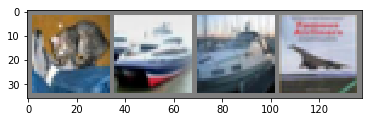

GroundTruth:    cat  ship  ship plane
Predicted:      cat   car   car plane


In [5]:
# Test resulting network
dataiter = iter(testloader)

# Get the next batch of images
images, labels = dataiter.next()

# Print images and ground truth
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Apply the network to the images
outputs = net(images)

# Select the most probable class for each example
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [6]:
# Test on whole test dataset
correct = 0
total = 0
confusion_matrix=np.zeros(shape=(10,10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for j in range(4):
          confusion_matrix[labels[j],predicted[j]]+=1

print('Accuracy of the network on 10000 test images: %d %%' % (
    100 * correct / total))

# Divide each row by number of examples (sum along the row)
# Express as a percentage
confusion_matrix*=(100.0/confusion_matrix.sum(1))
print(confusion_matrix)

Accuracy of the network on 10000 test images: 55 %
[[68.2  3.3  9.   4.1  1.3  0.6  1.   0.9  8.3  3.3]
 [ 4.9 74.6  3.1  2.2  0.5  0.2  1.3  0.5  4.5  8.2]
 [ 7.6  0.8 55.4 13.8  5.1  6.7  5.3  2.7  1.7  0.9]
 [ 3.1  1.1 14.6 51.   3.1 16.4  6.6  1.9  1.3  0.9]
 [ 5.3  0.2 29.5 11.8 33.5  4.5  7.6  5.8  1.   0.8]
 [ 1.5  0.3 14.  26.8  3.  46.5  2.4  4.4  0.6  0.5]
 [ 0.8  0.5 12.3 16.9  4.4  1.8 61.6  0.6  0.6  0.5]
 [ 3.4  0.2  8.2 12.9  8.2  9.3  0.9 54.1  0.4  2.4]
 [19.2  7.8  4.8  3.5  0.5  0.7  1.2  0.9 58.4  3. ]
 [ 8.  23.9  2.9  5.6  0.7  0.6  2.3  2.3  6.3 47.4]]
